In [13]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

In [14]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
import seaborn as sns
import matplotlib.ticker as ticker
from statannot import add_stat_annotation

In [15]:
def file_extraction(search_string, set): 
    filepaths = glob.glob(search_string) 
    df = pd.DataFrame()
    col_name_suffix = 1
    for find_files in filepaths:
        if set == 'ctrl':
            df = df.join (pd.read_excel(find_files, sheet_name='CTRL'), how='outer',lsuffix=col_name_suffix)
            col_name_suffix +=1
        else: 
            df = df.join (pd.read_excel(find_files, sheet_name='SE'), how='outer',lsuffix=col_name_suffix)
            col_name_suffix +=1
    return(df)

In [16]:
rec_count_CTRL= file_extraction('**/rec*.xlsx', set = 'ctrl')
rec_count_SE = file_extraction('**/rec*.xlsx', set = 'SE')
all_rec_count = pd.concat([rec_count_CTRL, rec_count_SE], ignore_index= True)

In [17]:
all_rec_count ['IGluT(5)/IGluT(1)'] = all_rec_count['IGluT(5)']/all_rec_count['IGluT(1)']
all_rec_count ['τdecay IGluT(5)/τdecay IGluT(1)'] = all_rec_count['τdecay IGluT(5)']/all_rec_count['τdecay IGluT(1)']

In [18]:
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [19]:
all_rec_count_ampl = pd.melt (all_rec_count, id_vars= ['Group'], value_vars=['IGluT(1)','IGluT(5)'],var_name= '', value_name= 'Амплитуда, pA')
all_rec_count_decay = pd.melt (all_rec_count, id_vars= ['Group'], value_vars=['τdecay IGluT(1)','τdecay IGluT(5)'],var_name= '', value_name= 'τdecay, мс')

In [20]:
def boxplot_graph_hue(data, dots, fig_name, big_tick, ylim, xyhue, box_pairs): 
    fig_name = 'figs/ElPhys measures/' + fig_name + '.tif'
    fig = plt.figure(figsize=(17,9)) # меняет размер графика
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(font_scale=2, style="ticks",context="poster", rc= custom_params)
    plot = sns.boxplot(data = data, x = xyhue[0], y = xyhue[1], hue = xyhue[2], 
                                            palette="vlag", linewidth = 7, dodge=True)
    
    plot.spines['left'].set_linewidth(4)
    plot.spines['bottom'].set_linewidth(4)
    plot.yaxis.set_major_locator(ticker.MultipleLocator(big_tick))
    plt.ylim(ylim)
    stat = add_stat_annotation(plot, data=data,x = xyhue[0], y = xyhue[1], hue = xyhue[2],
                    box_pairs=box_pairs,loc = 'outside',
                    test='Mann-Whitney', text_format='star',  verbose=1, comparisons_correction=None, linewidth=4) #loc = 'outside'
    if dots == True:
        sns.swarmplot(x = xyhue[0], y = xyhue[1], hue = xyhue[2], data=data, 
                                            size = 10, palette = "Set2", linewidth=3 ,dodge = True)
    handles, labels = plot.get_legend_handles_labels()
    plt.legend(handles[0:2], labels[0:2], loc=2, bbox_to_anchor=(1.03, 1), borderaxespad=0)
    adjust_box_widths(fig, 0.9)
    plot = plot.get_figure()
    plt.tight_layout()                                         
    plot.savefig(fig_name, dpi=800)
    return stat

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IGluT(5)_Контроль v.s. IGluT(5)_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=5.830e-01 U_stat=1.150e+01
IGluT(1)_Контроль v.s. IGluT(1)_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=1.000e+00 U_stat=1.550e+01


C:\Users\nosov\AppData\Local\Temp/ipykernel_21312/3610721994.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


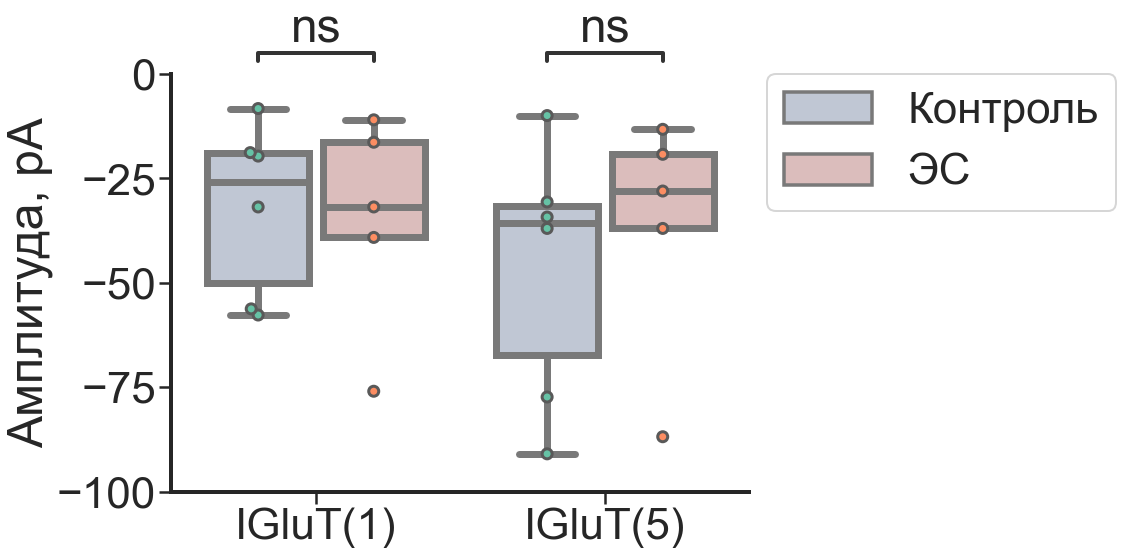

In [21]:
stat = boxplot_graph_hue(all_rec_count_ampl, dots = True, fig_name = 'амлитуды',big_tick = 25, ylim = [-100,0], 
                xyhue =['','Амплитуда, pA','Group'], box_pairs = [(('IGluT(1)', 'Контроль'),( 'IGluT(1)', 'ЭС')),
                                                                 (('IGluT(5)', 'Контроль'),('IGluT(5)', 'ЭС'))])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

τdecay IGluT(5)_Контроль v.s. τdecay IGluT(5)_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=3.030e-02 U_stat=3.000e+00
τdecay IGluT(1)_Контроль v.s. τdecay IGluT(1)_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=2.468e-01 U_stat=8.000e+00


C:\Users\nosov\AppData\Local\Temp/ipykernel_21312/3610721994.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


(<AxesSubplot:ylabel='τdecay, мс'>,
  <statannot.StatResult.StatResult at 0x19e127d6490>])

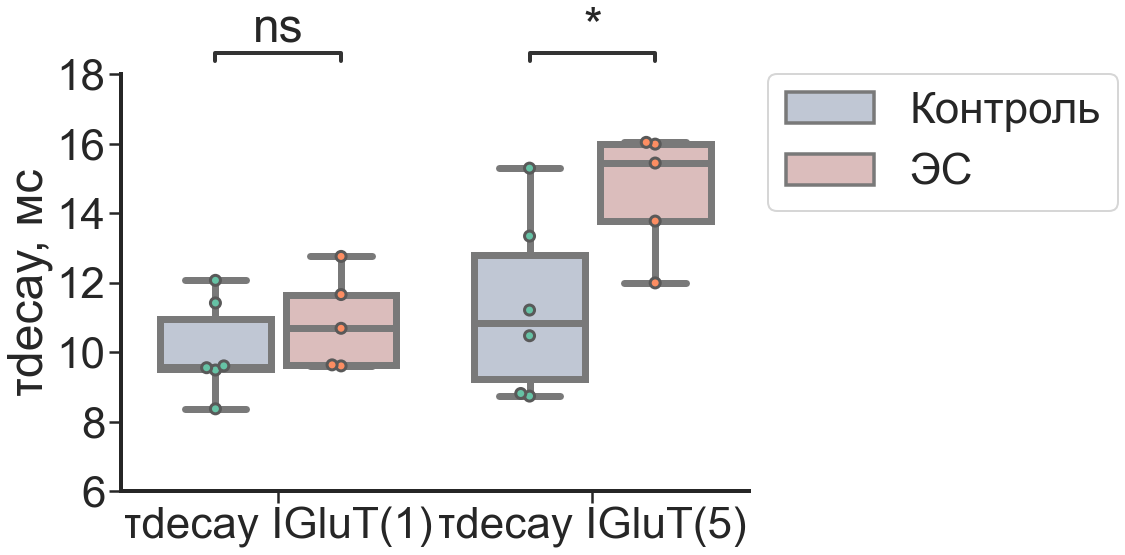

In [22]:
boxplot_graph_hue(all_rec_count_decay, dots = True, fig_name = 'время затухания',big_tick = 2, ylim = [6,18], 
                xyhue =['','τdecay, мс','Group'], box_pairs = [(('τdecay IGluT(1)', 'Контроль'),( 'τdecay IGluT(1)', 'ЭС')),
                                                                 (('τdecay IGluT(5)', 'Контроль'),('τdecay IGluT(5)', 'ЭС'))])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Контроль v.s. ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=4.413e-02 U_stat=2.650e+01


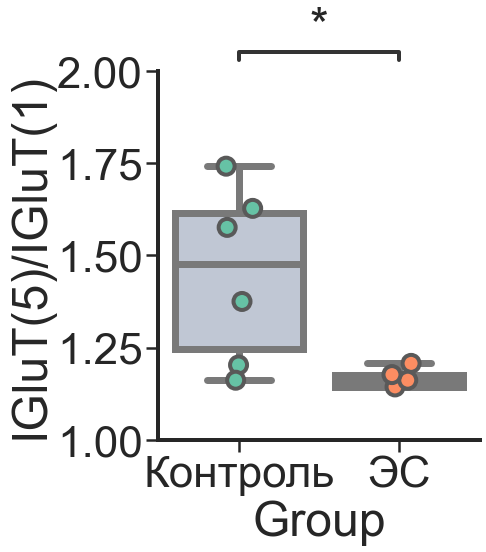

In [23]:
fig = plt.figure(figsize=(8,9)) # меняет размер графика
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=2, style="ticks",context="poster", rc= custom_params)
plot = sns.boxplot (data = all_rec_count, x=all_rec_count['Group'], y = all_rec_count['IGluT(5)/IGluT(1)'],  palette="vlag", linewidth = 7, dodge=True)
plot.spines['left'].set_linewidth(4)
plot.spines['bottom'].set_linewidth(4)
plot.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
plt.ylim([1,2])
stat = add_stat_annotation(plot, data = all_rec_count, x=all_rec_count['Group'], y = all_rec_count['IGluT(5)/IGluT(1)'],
                    box_pairs=[("Контроль", "ЭС")],loc = 'outside',
                    test='Mann-Whitney', text_format='star',  verbose=1, comparisons_correction=None, linewidth=4) #loc = 'outside'
sns.stripplot(data=all_rec_count, x=all_rec_count['Group'], y = all_rec_count['IGluT(5)/IGluT(1)'],
              size=17, linewidth=4,palette = "Set2", jitter = True)
plot = plot.get_figure()
plt.tight_layout() 
plot.savefig('figs/ElPhys measures/отношения амплитуд', dpi=800)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Контроль v.s. ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=1.255e-01 U_stat=6.000e+00


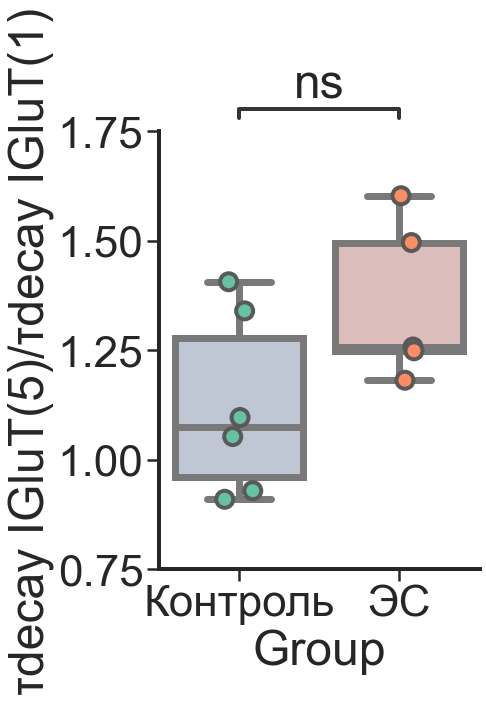

In [24]:
fig = plt.figure(figsize=(8,10)) # меняет размер графика
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(font_scale=2, style="ticks",context="poster", rc= custom_params)
plot = sns.boxplot (data = all_rec_count, x=all_rec_count['Group'], y = all_rec_count['τdecay IGluT(5)/τdecay IGluT(1)'],  palette="vlag", linewidth = 7, dodge=True)
plot.spines['left'].set_linewidth(4)
plot.spines['bottom'].set_linewidth(4)
plot.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
plt.ylim([0.75,1.75])
stat = add_stat_annotation(plot, data = all_rec_count, x=all_rec_count['Group'], y = all_rec_count['τdecay IGluT(5)/τdecay IGluT(1)'],
                    box_pairs=[("Контроль", "ЭС")],loc = 'outside',
                    test='Mann-Whitney', text_format='star',  verbose=1, comparisons_correction=None, linewidth=4) #loc = 'outside'
sns.stripplot(data=all_rec_count, x=all_rec_count['Group'], y = all_rec_count['τdecay IGluT(5)/τdecay IGluT(1)'],
              size=17, linewidth=4,palette = "Set2", jitter = True)
plot = plot.get_figure()
plt.tight_layout() 
plot.savefig('figs/ElPhys measures/отношения времени затухания', dpi=800)